In [1]:
import pickle
import random
import warnings

import dill
import gpytorch
import torch
from botorch.exceptions import BotorchWarning
from botorch.models import SingleTaskGP

import IBBKernel
import matplotlib.pyplot as plt
import numpy as np

from gen_sim import combine_sos

torch.set_default_device('cuda')
torch.set_default_dtype(torch.double)

In [2]:
def warped_posterior_plot(warper, model, x_data, y_data, num_steps=80, scatter=True): 
    fig = plt.figure(figsize=(12, 6))
    grid_x, grid_y = torch.meshgrid(torch.linspace(0, 500, num_steps), torch.linspace(0, 200, num_steps), indexing='ij')
    grid_x= grid_x.cuda()
    grid_y = grid_y.cuda()
    valid_grid =  ((grid_x - warper['h']) ** 2 / warper['a'] + warper['k'] >= grid_y)
    vgx = grid_x[valid_grid]
    vgy = grid_y[valid_grid]
    values = warp(warper, torch.stack((vgx, vgy), dim=1))
    post = model.posterior(values)
    mu = post.mean.detach().cpu().numpy()
    var = post.variance.detach().cpu().numpy()
    mu_full = np.full((num_steps, num_steps), np.nan)
    var_full = np.full((num_steps, num_steps), np.nan)
    grid_x = grid_x.detach().cpu().numpy()
    grid_y = grid_y.detach().cpu().numpy()
    mu_full[np.nonzero(valid_grid.detach().cpu().numpy())] = mu.squeeze()
    var_full[np.nonzero(valid_grid.detach().cpu().numpy())] = var.squeeze()
    ax = fig.add_subplot(121)
    CS = ax.contourf(grid_x, grid_y, mu_full, 20, cmap='RdBu_r', vmin=-np.nanmax(abs(mu_full)), vmax=np.nanmax(abs(mu_full)))
    if scatter:
        ax.scatter(x_data[:, 0].cpu(), x_data[:, 1].cpu(), c=y_data.cpu(),
                       edgecolors='k', cmap='RdBu_r', vmin=-np.nanmax(abs(mu_full)), vmax=np.nanmax(abs(mu_full)))
    cbar = plt.colorbar(CS, ax=ax)
    plt.plot(np.linspace(0, 500, 100), (np.linspace(0, 500, 100) - warper['h']) ** 2 / warper['a'] + warper['k'])
    plt.ylim([0, 200])
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    cbar.set_label('RT (s)')
    
    ax2 = fig.add_subplot(122)
    CS2 = ax2.contourf(grid_x, grid_y, var_full, 20)
    cbar2 = plt.colorbar(CS2, ax=ax2)
    plt.plot(np.linspace(0, 500, 100), (np.linspace(0, 500, 100) - warper['h']) ** 2 / warper['a'] + warper['k'])
    plt.ylim([0, 200])
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    cbar2.set_label('Variance')

In [16]:
warnings.simplefilter("ignore", BotorchWarning)

xs = torch.rand((2000), device='cuda')
ys = torch.rand((2000), device='cuda')
test_data = torch.cos(2*torch.pi*xs) + torch.cos(torch.pi*ys)
test_data += torch.randn(test_data.shape, device='cuda')
train_x = torch.stack((xs,ys), dim=1)

covar_module = gpytorch.kernels.ScaleKernel(IBBKernel.IBBKernel(50, 20))
covar_module.outputscale = 0.001
model = SingleTaskGP(train_x, test_data.unsqueeze(-1), torch.ones_like(test_data).unsqueeze(-1), covar_module=covar_module)

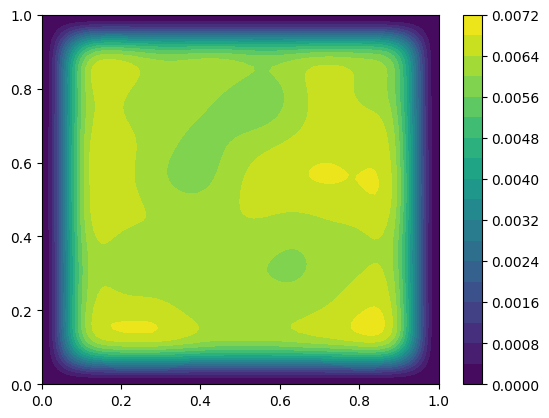

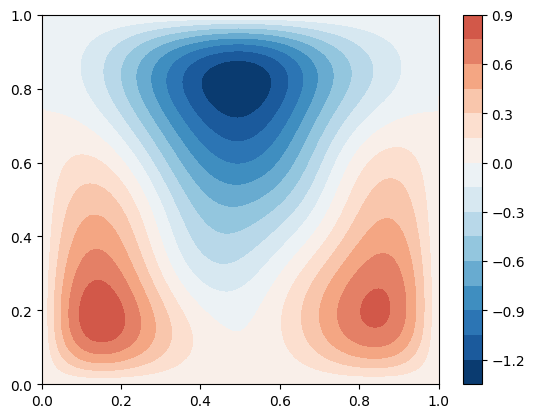

In [20]:
num_steps = 100
std = False
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_steps), np.linspace(0, 1, num_steps), indexing='ij')
values = np.concatenate([grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)], axis=1)
post = model.posterior(torch.tensor(values, device='cuda', dtype=torch.double),
                         observation_noise=False)
var = post.variance.detach().cpu().numpy()
fig = plt.figure()
ax = fig.add_subplot()
CS = plt.contourf(grid_x, grid_y, var.reshape((num_steps, num_steps)), 20)
cbar = plt.colorbar(CS, ax=ax)
fig2 = plt.figure()
ax2 = fig2.add_subplot()
mu = post.mean.detach().cpu().numpy()
CS2 = plt.contourf(grid_x, grid_y, mu.reshape((num_steps, num_steps)), 20, cmap='RdBu_r', vmin=-np.max(abs(mu)), vmax=np.max(abs(mu)))
cbar2 = plt.colorbar(CS2, ax=ax2)

In [3]:
def get_sample(sim, params, param_range):
    return (combine_sos(sim, params, param_range) / sim['scale'] * sim['mean_effect'] + np.random.normal(0, sim['std_effect'])) / sim['std_effect']

In [4]:
param_range = {'amp': (0, 500), 'pw': (0, 200)}

In [5]:
def warp(warper, input_data):
    x = input_data[:, 0]
    y = input_data[:, 1]

    if warper['h'] is None:
        return normalize(torch.stack((x, y), dim=1), warper['tensor_bounds'])

    x_2 = (200 - y) / warper['m'] + x  # Intersection of lines with upper boundary

    # Intersection of warp line through each point with safety bound
    x_1 = (-math.sqrt(warper['a']) * torch.sqrt(warper['a'] * warper['m'] ** 2 + 4 * warper['h'] * warper['m'] - 4 * warper['k'] - 4 * warper['m'] * x + 4 * y) + warper['a'] * warper['m'] + 2 * warper['h']) / 2
    
    y_1 = (x_1 - warper['h']) ** 2 / warper['a'] + warper['k']

    Do = torch.sqrt((y - y_1) ** 2 + (x - x_1) ** 2)  # Distance from each point to safety bound
    D = torch.sqrt((200 - y_1) ** 2 + (x_2 - x_1) ** 2)  # Distance to boundary for points to left of x_o

    y_2 = warper['m'] * (500 - x) + y  # Intersection of lines with right boundary
    D2 = torch.sqrt((y_2 - y_1) ** 2 + (500 - x_1) ** 2)  # Distance to boundary for points to right of x_o

    Ds = D
    Ds[x_1 > warper['x_o']] = D2[x_1 > warper['x_o']]

    y_2p = -warper['m'] * x + y  # Intersection of lines with left boundary
    x_2p = -y / warper['m'] + x  # Intersection of lines with lower boundary

    Dp = torch.sqrt((y_2p - y_1) ** 2 + x_1 ** 2)  # Distance from left boundary to safety bound along warp line
    Dp2 = torch.sqrt(y_1 ** 2 + (x_2p - x_1) ** 2)  # Distance from lower boundary to safety bound along warp line

    Dps = Dp
    Dps[x_2p > 0] = Dp2[x_2p > 0]

    dwarp = Ds * (Dps - Do) / Dps
    dwarp[x_1 < warper['h'] - math.sqrt(warper['a'] * (200 - warper['k']))] = 0
    dwarp[x_1 > 500] = 0

    warped = normalize(torch.stack((x + dwarp / math.sqrt(warper['m'] ** 2 + 1), y + dwarp * warper['m'] / math.sqrt(warper['m'] ** 2 + 1)), dim=1), warper['tensor_bounds'])
    warped[torch.isnan(warped[:,0]), :] = normalize(input_data[torch.isnan(warped[:,0]), :], warper['tensor_bounds'])
    return warped

In [6]:
def unwarp(warper, input_data):
    raw_data = unnormalize(input_data, warper['tensor_bounds'])
    x = raw_data[:, 0].detach().cpu().numpy()
    y = raw_data[:, 1].detach().cpu().numpy()

    if warper['h'] is None:
        return np.stack((x, y), axis=1)

    uw = np.zeros((x.shape[0], 2))

    for i in range(uw.shape[0]):
        x_o = sympy.Symbol('x_o', positive=True)
        y_o = sympy.Symbol('y_o', positive=True)

        try:
            # Intersection of warp line through each point with safety bound
            x_1 = (-math.sqrt(warper['a']) * math.sqrt(
                warper['a'] * warper['m'] ** 2 + 4 * warper['h'] * warper['m'] - 4 * warper['k'] - 4 * warper['m'] * x[i] + 4 * y[i]) + warper['a'] * warper['m'] + 2 * warper['h']) / 2
            y_1 = (x_1 - warper['h']) ** 2 / warper['a'] + warper['k']
            if y_1 > 200 or x_1 > 500:
                uw[i, 0] = x[i]
                uw[i, 1] = y[i]
            else:
                x_2 = (200 - y[i]) / warper['m'] + x[i]  # Intersection of lines with upper boundary
                y_2 = warper['m'] * (500 - x[i]) + y[i]  # Intersection of lines with right boundary
                
                y_2p = -warper['m'] * x[i] + y[i]  # Intersection of lines with left boundary
                x_2p = -y[i] / warper['m'] + x[i]  # Intersection of lines with lower boundary
                
                Dn = sympy.sqrt((y_o - max(y_2p, 0)) ** 2 + (x_o - max(x_2p, 0)) ** 2)
                Dtot = math.sqrt((min(y_2, 200) - max(y_2p, 0)) ** 2 + (min(x_2, 500) - max(x_2p, 0)) ** 2)
                Db = math.sqrt((y_1 - max(y_2p, 0)) ** 2 + (x_1 - max(x_2p, 0)) ** 2)
                Dw = math.sqrt((y[i] - max(y_2p, 0)) ** 2 + (x[i] - max(x_2p, 0)) ** 2)

                expr = Dn / Db - Dw / Dtot
                expr2 = warper['m'] * (x_o - x_1) + y_1 - y_o

                res = sympy.solve([expr.simplify(), expr2.simplify()], [x_o, y_o])

                uw[i, 0] = float(res[0][0])
                uw[i, 1] = float(res[0][1])
        except ValueError:
            uw[i, 0] = x[i]
            uw[i, 1] = y[i]
    return uw

In [7]:
def get_warper(sim):
     # Generate safety condition
    warper = {'h': sim['saf_h'], 'a': sim['saf_a'], 'k': sim['saf_k'], 'tensor_bounds': tensor_bounds}

    m = sympy.Symbol('m', real=True)
    x = sympy.Symbol('x')
    y = sympy.Symbol('y')
    a = sympy.Symbol('a')
    h = sympy.Symbol('h')
    k = sympy.Symbol('k')

    res = sympy.solve([(x - h) ** 2 / a + k - y, sympy.exp(m) * (x - 500) - y + 200], [x, y], dict=True)
    x_o = res[0][x]
    if sim['saf_h'] - math.sqrt(sim['saf_a'] * (200 - sim['saf_k'])) < 0:
        x_1 = 0
    else:
        x_1 = h - sympy.sqrt(a * (200 - k))
    y_1 = (500 - h) ** 2 / a + k
    dydx = 2 * (x - h) / a

    D1I = sympy.integrate(sympy.sqrt(1 + dydx ** 2), (x, x_1, x_o))
    D2I = sympy.integrate(sympy.sqrt(1 + dydx ** 2), (x, x_o, 500))

    expr = D1I / D2I - (500 - x_1) / (200 - y_1) * 2 / 5
    expr = expr.subs([(a, sim['saf_a']), (k, sim['saf_k']), (h, sim['saf_h'])])
    res2 = float(sympy.nsolve(expr, m, (-5, 5), solver='bisect'))
    warper['x_o'] = float(x_o.subs([(m, res2), (a, sim['saf_a']), (k, sim['saf_k']), (h, sim['saf_h'])]))
    warper['m'] = math.exp(res2)
     
    return warper

In [13]:
import sympy
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
import math
import copy
from botorch.exceptions import BotorchWarning
import warnings
from botorch.utils.transforms import unnormalize, normalize
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound, qLowerBoundMaxValueEntropy, PosteriorStandardDeviation

warnings.simplefilter("ignore", BotorchWarning)

with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims = pickle.load(handle)

tkwargs = {"dtype": torch.double, "device": 'cuda'}
bounds = [(0, 0), (500, 200)]
tensor_bounds = torch.atleast_2d(torch.tensor(bounds, **tkwargs))
init_params = [[0, 150, 300, 300, 150, 0], [0, 0, 0, 50, 50, 50]]
standard_bounds = torch.zeros(2, 2, **tkwargs)
standard_bounds[1] = 1

n_session = 8
n_trial = 150

aq_name = 'eg'

class EGProblem(Problem):
    def __init__(self, model, sim):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, xl=[0,0], xu=[1,1])
        self.model = model
        self.sim = sim
    
    def _evaluate(self, x, out, *args, **kwargs):
        t_x = torch.tensor(x)
        mu = self.model.posterior(t_x).mean
        var = self.model.posterior(t_x).variance
        out['F'] = torch.cat((mu, -var), dim=1).detach().cpu().numpy()
        out['G'] = -np.ones(out['F'].shape[0])

algorithm = NSGA2(pop_size=60)

results = []
# Iterate over simulations
for n, sim in enumerate(sims):
    results.append({})
    # results[-1]['hyperparams'] = []
    
    # Generate safety condition
    warper = get_warper(sim)
    
    # Generate samples for initialization parameters
    params = copy.deepcopy(init_params)
    samples = []
    for i in range(len(init_params[0])):
        samples.append(get_sample(sim, {'amp': init_params[0][i], 'pw': init_params[1][i]}, param_range))
    x_data = torch.tensor(init_params, **tkwargs).transpose(0, 1)
    y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
    warped_x_data = warp(warper, x_data)
    
    # Fit the GP model
    covar_module = gpytorch.kernels.ScaleKernel(IBBKernel.IBBKernel(50, 20))
    covar_module.outputscale = 0.001
    covar_module.raw_outputscale.requires_grad = False
    results[-1]['model'] = SingleTaskGP(warped_x_data, y_data, torch.ones_like(y_data), covar_module=covar_module)
    results[-1]['model'].mean_module.initialize(constant=0)
    results[-1]['model'].mean_module.raw_constant.requires_grad = False
    # mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
    # fit_gpytorch_mll(mll)
    # results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
    
    # Run n_session sessions of n_trial trials
    for i in range(n_trial * n_session):
        if aq_name != 'eg':
            if aq_name == 'gibbon':
                candidate_set = torch.rand(100, tensor_bounds.size(1), **tkwargs)
                acq_func = qLowerBoundMaxValueEntropy(results[-1]['model'], candidate_set, maximize=False)
            elif aq_name == 'ucb':
                d = 0.01
                t = len(init_params[0]) + i
                beta = 2 * np.log(t ** 3 * math.pi ** 2 / (3 * d))
                acq_func = UpperConfidenceBound(results[-1]['model'], beta=beta, maximize=False)
            elif aq_name == 'std':
                acq_func = PosteriorStandardDeviation(results[-1]['model'])
            
            # Optimize the acquisition function with the safety condition
            candidates, val = optimize_acqf(
                acq_function=acq_func,
                bounds=standard_bounds,
                q=1,
                num_restarts=10,
                raw_samples=128,
                sequential=False,
            )
            candidate = unwarp(warper, candidates)
        else:
            epsilon = 0.9
            res = minimize(EGProblem(results[-1]['model'], sim),
               algorithm,
               seed=1,
               termination=('n_gen', 30))
            if random.random() < epsilon:
                candidate = np.expand_dims(res.X[random.randint(0, res.X.shape[0] - 1)], axis=0)
            else:
                candidate = np.expand_dims(res.X[torch.argmin(res.F[:, :0]), :], axis=0)
            candidate = unwarp(warper, torch.tensor(candidate))
        
        # Update model with new sample
        params[0].append(candidate[0, 0].item())
        params[1].append(candidate[0, 1].item())
        samples.append(get_sample(sim, {'amp': params[0][-1], 'pw': params[1][-1]}, param_range))
        x_data = torch.tensor(params, **tkwargs).transpose(0, 1)
        y_data = torch.unsqueeze(torch.tensor(samples, **tkwargs), dim=-1)
        warped_x_data = warp(warper, x_data)
        results[-1]['model'] = SingleTaskGP(warped_x_data, y_data, torch.ones_like(y_data), covar_module=covar_module)
        results[-1]['model'].mean_module.initialize(constant=0)
        results[-1]['model'].mean_module.raw_constant.requires_grad = False
        
        # Reoptimize hyperparameters after each session
        if i % n_trial == n_trial - 1:
            # warped_posterior_plot(warper, results[-1]['model'], x_data, y_data)
            # plt.show()
            # mll = ExactMarginalLogLikelihood(results[-1]['model'].likelihood, results[-1]['model'])
            # fit_gpytorch_mll(mll)
            # results[-1]['hyperparams'].append(copy.deepcopy(results[-1]['model'].state_dict()))
            print(f'{n}_{i}')

with open(f'outcomes/outcomes_{aq_name}_corrected_2.pickle', 'wb') as handle:
    dill.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0_149
0_299
0_449
0_599
0_749
0_899
0_1049
0_1199
1_149
1_299
1_449
1_599
1_749
1_899
1_1049
1_1199
2_149
2_299
2_449
2_599
2_749
2_899
2_1049
2_1199
3_149
3_299
3_449
3_599
3_749
3_899
3_1049
3_1199
4_149
4_299
4_449
4_599
4_749
4_899
4_1049
4_1199
5_149
5_299
5_449
5_599
5_749
5_899
5_1049
5_1199
6_149
6_299
6_449
6_599
6_749
6_899
6_1049
6_1199
7_149
7_299
7_449
7_599
7_749
7_899
7_1049
7_1199
8_149
8_299
8_449
8_599
8_749
8_899
8_1049
8_1199
9_149
9_299
9_449
9_599
9_749
9_899
9_1049
9_1199
10_149
10_299
10_449
10_599
10_749
10_899
10_1049
10_1199
11_149
11_299
11_449
11_599
11_749
11_899
11_1049
11_1199
12_149
12_299
12_449
12_599
12_749
12_899
12_1049
12_1199
13_149
13_299
13_449
13_599
13_749
13_899
13_1049
13_1199
14_149
14_299
14_449
14_599
14_749
14_899
14_1049
14_1199
15_149
15_299
15_449
15_599
15_749
15_899
15_1049
15_1199
16_149
16_299
16_449
16_599
16_749
16_899
16_1049
16_1199
17_149
17_299
17_449
17_599
17_749
17_899
17_1049
17_1199
18_149
18_299
18_449
18_599
18_749
1

In [14]:
from botorch.acquisition import PosteriorMean

performance = []
i = 0
for outcome, sim in zip(results, sims):
    performance.append([])
    warper = get_warper(sim)
    covar_module = gpytorch.kernels.ScaleKernel(IBBKernel.IBBKernel(50, 20))
    covar_module.outputscale = 0.001
    covar_module.raw_outputscale.requires_grad = False
    for j in range(8):
        model = SingleTaskGP(outcome['model'].train_inputs[0][:(j+1)*n_trial+6,:], torch.unsqueeze(outcome['model'].train_targets[:(j+1)*n_trial+6], dim=1), torch.ones(((j+1)*n_trial+6), 1), covar_module=covar_module)
        model.mean_module.initialize(constant=0)
        model.mean_module.raw_constant.requires_grad = False
        acqf = PosteriorMean(model, maximize=False)
        
        
        opt = optimize_acqf(
            acq_function=acqf,
            bounds=standard_bounds,
            q=1,
            raw_samples=512,
            num_restarts=10,
        )
        opt_loc = unwarp(warper, opt[0])
        performance[-1].append(combine_sos(sim, {'amp': opt_loc[0, 0], 'pw': opt_loc[0, 1]}, sim['param_ranges']) / sim['scale'])
        print(str(i) + ' ' + str(j))
    i += 1
with open(f'outcomes/performance_{aq_name}_corrected_2.pickle', 'wb') as handle:
    pickle.dump(performance, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
20 0
20 1
20 2
20 3
20 4
20 5
20 6
20 7
21 0
21 1
21 2
21 3
21 4
21 5
21 6
21 7
22 0
22 1
22 2
22 3
22 4
22 5
22 6
22 7
23 0
23 1
23 2
23 3
23 4
23 5
23 6
23 7
24 0
24 1
24 2
24 3
24 4
24 5
24 6
24 7
25 0
25 1
25 2
25 3
25 4
25 5
25 6
25 7
26 0
26 1
26 2
26 3
26 4
26 5
26 6
26 7


In [11]:
sims_full = []
with open('sims_100_01-06.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
with open('sims_100_01-06_2.pickle', 'rb') as handle:
    sims_full += pickle.load(handle)
on_boundary = []
for sim in sims_full:
    x = sim['optimal_loc'][0]
    y = sim['optimal_loc'][1]
    on_safety = ((x - sim['saf_h']) ** 2 /sim['saf_a'] + sim['saf_k']) - y
    on_boundary.append(on_safety < 10 or x < 25 or x > 475 or y < 10 and y > 190)
on_boundary_vec = np.asarray(on_boundary)
on_boundary = on_boundary_vec.reshape((int(on_boundary_vec.shape[0]/6), 6))

([<matplotlib.axis.XTick at 0x231663977f0>,
 [Text(0.1, 0, '0.1'),
  Text(0.2, 0, '0.2'),
  Text(0.3, 0, '0.3'),
  Text(0.4, 0, '0.4'),
  Text(0.5, 0, '0.5'),
  Text(0.6, 0, '0.6')])

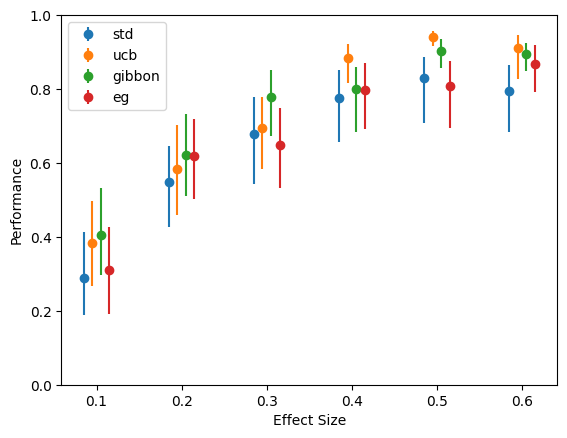

In [12]:
import os
from scipy.stats import bootstrap

acqfs = ['std', 'ucb', 'gibbon', 'eg']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    j = 2
    perf_mat = np.asarray(performance)
    while os.path.isfile(f'outcomes/performance_{acq}_corrected_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_corrected_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    conditions = perf_mat[:,-1].reshape((int(perf_mat.shape[0]/6), 6))
    conditions[on_boundary] = np.nan
    m_c = np.nanmean(conditions, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(conditions.shape[1]):
        res = bootstrap((conditions[:,j],), np.nanmean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(effect_sizes + (i - 2) * 0.01 + 0.005, m_c, yerr=(m_c-l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.xlabel('Effect Size')
plt.ylabel('Performance')
plt.ylim(0, 1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
plt.xticks(effect_sizes)

([<matplotlib.axis.YTick at 0x1c437513d30>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

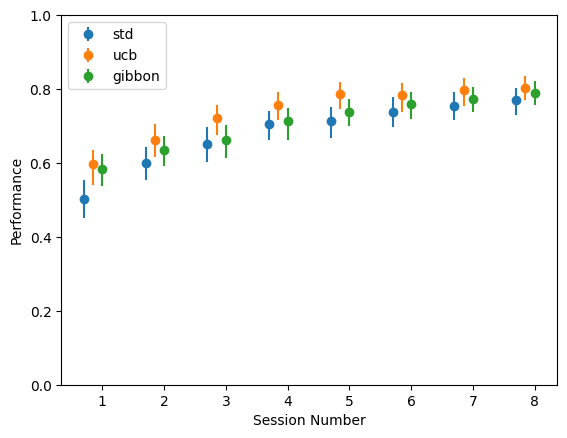

In [96]:
from scipy.stats import bootstrap

acqfs = ['std', 'ucb', 'gibbon']
effect_sizes = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
fig = plt.figure()
for i, acq in enumerate(acqfs):
    with open(f'outcomes/performance_{acq}_corrected.pickle', 'rb') as handle:
        performance = pickle.load(handle)
    perf_mat = np.asarray(performance)
    j = 2
    while os.path.isfile(f'outcomes/performance_{acq}_corrected_{j}.pickle'):
        with open(f'outcomes/performance_{acq}_corrected_{j}.pickle', 'rb') as handle:
            perf_mat = np.concatenate((perf_mat, np.asarray(pickle.load(handle))), axis=0)
        j += 1
    perf_mat[on_boundary_vec] = np.nan
    m_c = np.nanmean(perf_mat, axis=0)
    l_c = np.zeros_like(m_c)
    h_c = np.zeros_like(m_c)
    for j in range(perf_mat.shape[1]):
        res = bootstrap((perf_mat[:,j],), np.nanmean, n_resamples=1000)
        l_c[j] = res.confidence_interval.low
        h_c[j] = res.confidence_interval.high
    plt.errorbar(np.arange(1,9) + (i - 2) * 0.15, m_c, yerr=(m_c - l_c, h_c-m_c), linestyle='none', marker='o')
plt.legend(acqfs, loc='upper left')
plt.xlabel('Session Number')
plt.ylabel('Performance')
plt.xticks(np.arange(1,9))
plt.ylim(0, 1)
plt.yticks([0,0.2,0.4,0.6,0.8,1])

In [12]:
def plot_ground_truth(sim, param_range, orientation='vertical'):
    x = np.linspace(0, 500, 100)
    y = np.linspace(0, 200, 100)
    X, Y = np.meshgrid(x, y)
    surface = np.zeros(X.shape)
    for i in range(surface.shape[0]):
        for j in range(surface.shape[1]):
            surface[i][j] = (combine_sos(sim, {'amp': x[i], 'pw': y[j]}, param_range)) / sim['scale'] * sim['mean_effect'] / sim['std_effect']
    
    ax = plt.gca()
    CS = ax.contourf(X.transpose(), Y.transpose(), surface, 100, cmap='RdBu_r', vmin=-np.max(abs(surface)),
                     vmax=np.max(abs(surface)))
    plt.plot(x, (x - sim['saf_h']) ** 2 / sim['saf_a'] + sim['saf_k'], color='black')
    cbar = plt.gcf().colorbar(CS, ax=ax, orientation=orientation)
    plt.ylabel('Pulse Width ($\\mu$s)')
    plt.xlabel('Amplitude ($\\mu$A)')
    plt.ylim([0, 200])
    cbar.set_label('Stim Effect')
    return cbar

KeyboardInterrupt: 

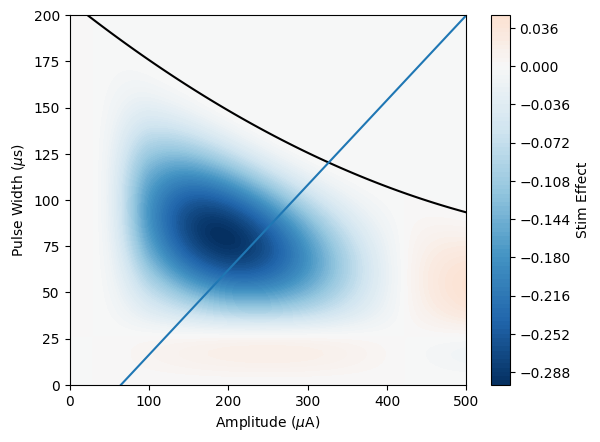

In [61]:
plot_ground_truth(sim, param_range)
plt.plot(np.linspace(0,500,10), 200 + warper['m'] * (np.linspace(0,500,10) - 500))
steps = np.linspace(0,500,100)
stacked = np.stack((steps, (steps - warper['h']) ** 2 / warper['a'] + warper['k']), axis=1)
warped = warp(warper, torch.tensor(stacked[stacked[:,1] < 200,:]))
pts = unwarp(warper, candidates)
warped = warped.detach().cpu().numpy()
plt.scatter(warped[:,0]*500, warped[:,1]*200)
plt.scatter(pts[:, 0], pts[:, 1])
plt.scatter(candidates[0][0].item()*500, candidates[0][1].item()*200)

In [18]:
temp = results[2]['model'].train_inputs[0][-150:,:].detach().cpu().numpy()

In [59]:
warper2 = get_warper(sim)